FGSM on a simple fnn

In [11]:
from sklearn.datasets import load_digits
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std dev for MNIST
])

# Load training and test datasets
train_dataset = datasets.MNIST(root='./../data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False, transform=transform)

train_size = len(train_dataset) // 4
test_size = len(test_dataset) // 4

train_subset = Subset(train_dataset, torch.randperm(len(train_dataset))[:train_size])
test_subset = Subset(test_dataset, torch.randperm(len(test_dataset))[:test_size])

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(train_dataset), shuffle=False)

In [13]:
len(train_dataset)

60000

In [14]:
# Simple FFN approach

class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)

        logits = self.linear_relu_stack(x)
        return logits
        return F.softmax(logits, dim=0)

In [ ]:
# Training loop

model = FFN()

epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(epochs):
    for data_batch, label_batch in train_loader:
        output = model(data_batch)
        loss = loss_fn(output, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(loss.item())

2.3430538177490234


In [43]:
import matplotlib.pyplot as plt

def plot_img(img, label=None):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray_r')
    if label is not None:
        plt.title(f"Label: {label}")
        
    plt.tight_layout()
    plt.show()

In [71]:
# FGSM

# new image = original image + perturbation scalar * neg (gradient with respect to the loss)

def FGSM(img, target, scalar=3):
    img = img.clone().view(-1).detach().requires_grad_(True)  # Input usually doesnt require grad
    y = model(img)
    loss = loss_fn(y, target)
    loss.backward()
    grad = img.grad.data
    signed_grad = grad.sign()
    mod_img = img + (scalar * signed_grad)
    return mod_img.detach()

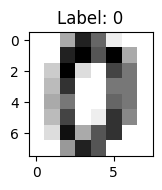

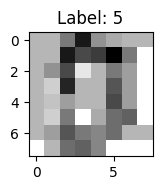

In [72]:
plot_img(data_tensor[0].view(8, 8), torch.argmax(target_tensor[0]))

modified = FGSM(data_tensor[0], target_tensor[0])
modified_label = torch.argmax(model(modified))

plot_img(modified.view(8, 8), modified_label)

In [5]:
# Eval
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, one_hot_labels in test_loader:
        data, one_hot_labels = data, one_hot_labels

        outputs = model(data)  # logits
        predicted = torch.argmax(outputs, dim=1)  # class indices
        true_labels = torch.argmax(one_hot_labels, dim=1)  # class indices from one-hot

        correct += (predicted == true_labels).sum().item()
        total += true_labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.94%
